
# Applying Temporal Convonotional Networks to the Virtual Flow Metering Problem 

## Author: Ridha Alkhabaz 

### Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# for tcn applications
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing import sequence
from tcn import TCN, compiled_tcn
import tensorflow as tf
import os
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/ElectricDemandForecasting-DL/src/")
from models import tcn
# for data configurations
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm

### Data configuration and Reading:

#### First: Riser data:

##### Reading the data and formating:

In [3]:
# Convert the sequence of seconds into datetime array
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z

In [4]:
# Read the data from fname and eventually plot them
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values

    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]
    
#     # some outliers and spikes
#     data[i][1] = np.random.uniform(1,2.5)
#         data[i][2] = np.random.uniform(1,2.5)
#         data[i][3] = np.random.uniform(1,2.5)
#         data[i][4] = np.random.uniform(1,2)
#         data[i][5] = np.random.uniform(1,2)
#         data[i][6] = np.random.uniform(1,2)
#         data[i][7] = np.random.uniform(0.95,1.1)
#         data[i][8] = np.random.uniform(-0.2,0.6)
#         data[i][9] = np.random.uniform(-100,320)
        
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)

    return data, scaler

##### Sliding window technique (Data configuration):

In [5]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
data_riser, _= read_data('riser_pq_uni.csv')
df_riser = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data_riser.T)))
### previous readings for univariate model 
dt_gas_riser = np.array(df_riser['gas(m3/day)'])
dt_liquid_riser = np.array(df_riser['liquid(m3/day)'])
### gas and liquid dataframe
df_gas_riser = df_riser.drop('liquid(m3/day)', axis=1)
df_gas_riser = df_gas_riser.set_index('ds')
df_liquid_riser = df_riser.drop('gas(m3/day)', axis=1)
df_liquid_riser = df_liquid_riser.set_index('ds')

###### Removing some values:

In [ ]:
from random import randint
index = [randint(0, len(df_riser)) for i in range(100)]
df_riser.iloc[index,[1,2,3,4,5,6, 7, 8, 9]] = 0

###### Adding some gaussian noise:

In [ ]:
df_riser = df_riser.set_index('ds')
mu, sigma = 0, 5e-3
noise = np.random.normal(mu, sigma, df_riser.shape)
df_riser = df_riser + noise

###### Some visualization for the data:

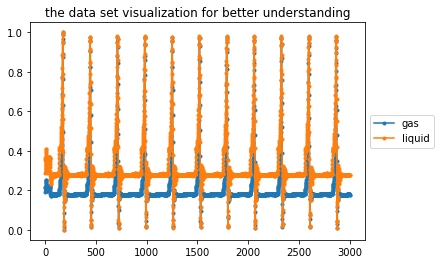

In [6]:
df_riser = df_riser.reset_index()
fig,ax = plt.subplots()
ax.set_title('the data set visualization for better understanding')
ax.plot(df_riser['ds'], df_riser['gas(m3/day)'], marker=".", label='gas')
ax.plot(df_riser['ds'], df_riser['liquid(m3/day)'], marker=".", label='liquid')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_riser = df_riser.set_index('ds')

##### Hyperparameters for the model:

In [7]:
# Model Hyperparemeters (general hyperparameters)
FORECAST_HORIZON = 5 #secs 
PAST_HISTORY = 300
BATCH_SIZE = 64
EPOCHS = 100
METRICS = ['mse']

In [9]:
##  gas (univariate)
batch_size, timesteps, input_dim = 64, 300, 1
output_timesteps = 5


model_gas_uni = Sequential(
    layers=[
        TCN(input_shape=(timesteps, input_dim)),  # output.shape = (batch, 64)
        Dense(output_timesteps)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_uni.summary()
model_gas_uni.compile('adam', 'mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [10]:
## gas (multivariate)
batch_size, timesteps, input_dim = 64, 300, 8
output_timesteps = 5


model_gas_mult = Sequential(
    layers=[
        TCN(input_shape=(timesteps, input_dim)),  # output.shape = (batch, 64)
        Dense(output_timesteps)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_gas_mult.summary()
model_gas_mult.compile('adam', 'mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 64)                138048    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 138,373
Trainable params: 138,373
Non-trainable params: 0
_________________________________________________________________


In [11]:
## liquid (univariate)
batch_size, timesteps, input_dim = 64, 300, 1
output_timesteps, output_dim = 5, 1


model_liq_uni = Sequential(
    layers=[
        TCN(input_shape=(timesteps, input_dim)),  # output.shape = (batch, 64)
        Dense(output_timesteps)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_liq_uni.summary()
model_liq_uni.compile('adam', 'mse')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 136,581
Trainable params: 136,581
Non-trainable params: 0
_________________________________________________________________


In [12]:
## liquid  (multivariate)
batch_size, timesteps, input_dim = 64, 300, 8
output_timesteps = 5


model_liquid_mult = Sequential(
    layers=[
        TCN(input_shape=(timesteps, input_dim)),  # output.shape = (batch, 64)
        Dense(output_timesteps)  # output.shape = (batch, output_timesteps, 64)
    ]
)

model_liquid_mult.summary()
model_liquid_mult.compile('adam', 'mse')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_4 (TCN)                  (None, 64)                138048    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 138,373
Trainable params: 138,373
Non-trainable params: 0
_________________________________________________________________


#### Using only previous readings as an input:

In [13]:
def univariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    for i in range(start_index, end_index - forecast_horizon + 1):
        indices = range(i - history_size, i, step)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(tseries[indices], (history_size, 1)))

        if single_step:
            labels.append(tseries[i + forecast_horizon])
        else:
            labels.append(tseries[i:i + forecast_horizon])

    return np.array(data), np.array(labels)

In [14]:
##gas
## we are going to consider gas for now
x_gas_uni, y_gas_uni = univariate_data(dt_gas_riser, 0, 1500, 300, 5, step=1, single_step=False)
valX_gas_uni , valY_gas_uni = univariate_data(dt_gas_riser, 1500, 2500, 300, 5, step=1, single_step=False)
testX_gas_riser_uni, testY_gas_riser_uni = univariate_data(dt_gas_riser,2500, 3000, 300, 5, step=1, single_step=False)
# to avoid combatibality issues
x_gas_uni = x_gas_uni.astype(np.float32)
y_gas_uni = y_gas_uni.astype(np.float32)
valX_gas_uni = valX_gas_uni.astype(np.float32)
valY_gas_uni = valY_gas_uni.astype(np.float32)
testX_gas_riser_uni = testX_gas_riser_uni.astype(np.float32)
testY_gas_riser_uni = testY_gas_riser_uni.astype(np.float32)
##liquid
## we are going to consider gas for now
x_liq_uni, y_liq_uni = univariate_data(dt_liquid_riser, 0, 1500, 300, 5, step=1, single_step=False)
valX_liq_uni , valY_liq_uni = univariate_data(dt_liquid_riser, 1500, 2500, 300, 5, step=1, single_step=False)
testX_liq_riser_uni, testY_liq_riser_uni = univariate_data(dt_liquid_riser,2500, 3000, 300, 5, step=1, single_step=False)
# to avoid combatibality issues
x_liq_uni = x_liq_uni.astype(np.float32)
y_liq_uni = y_liq_uni.astype(np.float32)
valX_liq_uni = valX_liq_uni.astype(np.float32)
valY_liq_uni = valY_liq_uni.astype(np.float32)
testX_liq_riser_uni = testX_liq_riser_uni.astype(np.float32)
testY_liq_riser_uni = testY_liq_riser_uni.astype(np.float32)

In [15]:
##gas 
train_data_gas_uni = tf.data.Dataset.from_tensor_slices((x_gas_uni, y_gas_uni)).cache().batch(BATCH_SIZE).repeat()
val_data_gas_uni = tf.data.Dataset.from_tensor_slices((valX_gas_uni, valY_gas_uni)).batch(BATCH_SIZE).repeat()
##liquid 
train_data_liq_uni = tf.data.Dataset.from_tensor_slices((x_liq_uni, y_liq_uni)).cache().batch(BATCH_SIZE).repeat()
val_data_liq_uni = tf.data.Dataset.from_tensor_slices((valX_liq_uni, valY_liq_uni)).batch(BATCH_SIZE).repeat()

In [17]:
##gas 
evaluation_gas_interval = int(np.ceil(x_gas_uni.shape[0] / BATCH_SIZE))
history_gas_uni = model_gas_uni.fit(train_data_gas_uni, epochs=200, steps_per_epoch=evaluation_gas_interval, validation_data=val_data_gas_uni, validation_steps=evaluation_gas_interval)

Epoch 1/200
19/19 [==============================] - 8s 441ms/step - loss: 0.1418 - val_loss: 0.0405
Epoch 2/200
19/19 [==============================] - 8s 425ms/step - loss: 0.0254 - val_loss: 0.0134
Epoch 3/200
19/19 [==============================] - 8s 405ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 4/200
19/19 [==============================] - 8s 407ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 5/200
19/19 [==============================] - 8s 405ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 6/200
19/19 [==============================] - 8s 422ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 7/200
19/19 [==============================] - 8s 422ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 8/200
19/19 [==============================] - 8s 419ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/200
19/19 [==============================] - 8s 403ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 10/200
19/19 [==============================] - 8s 403ms/step - loss: 0.0039 - val_lo

19/19 [==============================] - 10s 520ms/step - loss: 2.5588e-04 - val_loss: 2.9866e-04
Epoch 79/200
19/19 [==============================] - 9s 473ms/step - loss: 2.8390e-04 - val_loss: 3.6760e-04
Epoch 80/200
19/19 [==============================] - 10s 532ms/step - loss: 3.3677e-04 - val_loss: 4.5674e-04
Epoch 81/200
19/19 [==============================] - 9s 472ms/step - loss: 4.0506e-04 - val_loss: 5.8556e-04
Epoch 82/200
19/19 [==============================] - 8s 432ms/step - loss: 5.3136e-04 - val_loss: 8.1043e-04
Epoch 83/200
19/19 [==============================] - 9s 463ms/step - loss: 7.3295e-04 - val_loss: 0.0011
Epoch 84/200
19/19 [==============================] - 9s 487ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 85/200
19/19 [==============================] - 12s 632ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 86/200
19/19 [==============================] - 12s 628ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 87/200
19/19 [===========================

19/19 [==============================] - 8s 416ms/step - loss: 6.5086e-04 - val_loss: 4.3722e-04
Epoch 154/200
19/19 [==============================] - 8s 420ms/step - loss: 5.1667e-04 - val_loss: 2.0223e-04
Epoch 155/200
19/19 [==============================] - 12s 653ms/step - loss: 2.4249e-04 - val_loss: 1.0717e-04
Epoch 156/200
19/19 [==============================] - 10s 495ms/step - loss: 1.2432e-04 - val_loss: 1.0358e-04
Epoch 157/200
19/19 [==============================] - 8s 439ms/step - loss: 1.1151e-04 - val_loss: 1.2552e-04
Epoch 158/200
19/19 [==============================] - 8s 427ms/step - loss: 1.3120e-04 - val_loss: 1.6701e-04
Epoch 159/200
19/19 [==============================] - 8s 430ms/step - loss: 1.7284e-04 - val_loss: 2.4532e-04
Epoch 160/200
19/19 [==============================] - 8s 445ms/step - loss: 2.7077e-04 - val_loss: 4.3628e-04
Epoch 161/200
19/19 [==============================] - 8s 441ms/step - loss: 5.2662e-04 - val_loss: 7.5872e-04
Epoch 162/200

In [19]:
##liquid 
evaluation_liq_interval = int(np.ceil(x_liq_uni.shape[0] / BATCH_SIZE))
history_liq_uni = model_liq_uni.fit(train_data_liq_uni, epochs=0, steps_per_epoch=evaluation_liq_interval, validation_data=val_data_liq_uni, validation_steps=evaluation_liq_interval)

Epoch 1/40
19/19 [==============================] - 10s 415ms/step - loss: 27.4355 - val_loss: 0.3396
Epoch 2/40
19/19 [==============================] - 8s 402ms/step - loss: 0.2356 - val_loss: 0.0644
Epoch 3/40
19/19 [==============================] - 8s 404ms/step - loss: 0.0516 - val_loss: 0.0349
Epoch 4/40
19/19 [==============================] - 8s 424ms/step - loss: 0.0275 - val_loss: 0.0219
Epoch 5/40
19/19 [==============================] - 8s 405ms/step - loss: 0.0187 - val_loss: 0.0162
Epoch 6/40
19/19 [==============================] - 8s 405ms/step - loss: 0.0145 - val_loss: 0.0128
Epoch 7/40
19/19 [==============================] - 8s 406ms/step - loss: 0.0114 - val_loss: 0.0106
Epoch 8/40
19/19 [==============================] - 8s 406ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 9/40
19/19 [==============================] - 8s 406ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 10/40
19/19 [==============================] - 8s 403ms/step - loss: 0.0068 - val_loss: 0.00

In [20]:
##gas
mean_squared_error(model_gas_uni.predict(testX_gas_riser_uni).flatten(), testY_gas_riser_uni.flatten())

0.0013210311

In [21]:
##liquid 
mean_squared_error(model_liq_uni.predict(testX_liq_riser_uni).flatten(), testY_liq_riser_uni.flatten())

0.0030128933

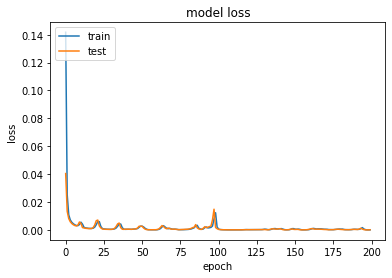

In [18]:
##gas
# summarize history for loss
plt.plot(history_gas_uni.history['loss'])
plt.plot(history_gas_uni.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

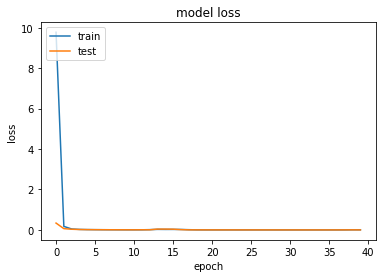

In [23]:
##liquid
# summarize history for loss
plt.plot(history_liq_uni.history['loss'])
plt.plot(history_liq_uni.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
## gas testing data set visualization
real_gas_uni = testY_gas_riser_uni.flatten()
pred_gas_uni = model_gas_uni.predict(testX_gas_riser_uni).flatten()
df_plot_gas_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_gas_uni['ds']=range(0,len(real_gas_uni))
##liquid
real_liq_uni = testY_liq_riser_uni.flatten()
pred_liq_uni = model_liq_uni.predict(testX_liq_riser_uni).flatten()
df_plot_liq_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_liq_uni['ds']=range(0,len(real_liq_uni))

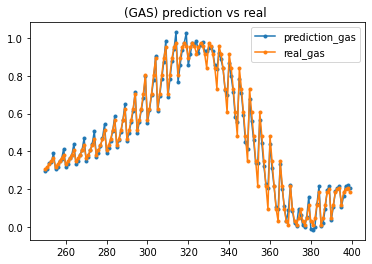

In [20]:
start = 250
end = 400
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real ')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

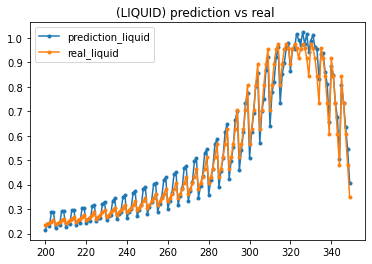

In [26]:
start = 200
end = 350
fig,ax = plt.subplots()
ax.set_title('(LIQUID) prediction vs real ')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['prediction'].iloc[start:end], marker=".", label='prediction_liquid')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['real'].iloc[start:end], marker=".", label='real_liquid')
ax.legend()

##### Using previous readings of pressure and flowrate:

In [22]:
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size +1, forecast_horizon):
        end = i+history_size
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+forecast_horizon, 7:])
    return np.array(data), np.array(labels)

In [23]:
## gas
x_gas_mult, y_gas_mult= multivariate_data(np.array(df_gas_riser), 0, 1500, PAST_HISTORY, FORECAST_HORIZON)
valX_gas_mult , valY_gas_mult = multivariate_data(np.array(df_gas_riser), 1500, 2500, PAST_HISTORY, FORECAST_HORIZON)
testX_gas_riser_mult, testY_gas_riser_mult = multivariate_data(np.array(df_gas_riser), 2500, 2999, PAST_HISTORY, FORECAST_HORIZON)
# to avoid combatibility issues
x_gas_mult = x_gas_mult.astype(np.float32)
y_gas_mult = y_gas_mult.astype(np.float32)
valX_gas_mult = valX_gas_mult.astype(np.float32)
valY_gas_mult = valY_gas_mult.astype(np.float32)
testX_gas_riser_mult = testX_gas_riser_mult.astype(np.float32)
testY_gas_riser_mult = testY_gas_riser_mult.astype(np.float32)
## liquid 
x_liq_mult, y_liq_mult= multivariate_data(np.array(df_liquid_riser), 0, 1500, PAST_HISTORY, FORECAST_HORIZON)
valX_liq_mult , valY_liq_mult = multivariate_data(np.array(df_liquid_riser), 1500, 2500, PAST_HISTORY, FORECAST_HORIZON)
testX_liq_riser_mult, testY_liq_riser_mult = multivariate_data(np.array(df_liquid_riser), 2500, 2999, PAST_HISTORY, FORECAST_HORIZON)
# to avoid combatibility issues
x_liq_mult = x_liq_mult.astype(np.float32)
y_liq_mult = y_liq_mult.astype(np.float32)
valX_liq_mult = valX_liq_mult.astype(np.float32)
valY_liq_mult = valY_liq_mult.astype(np.float32)
testX_liq_riser_mult = testX_liq_riser_mult.astype(np.float32)
testY_liq_riser_mult = testY_liq_riser_mult.astype(np.float32)

In [24]:
## gas
train_data_gas_mult = tf.data.Dataset.from_tensor_slices((x_gas_mult, y_gas_mult)).cache().batch(BATCH_SIZE).repeat()
val_data_gas_mult = tf.data.Dataset.from_tensor_slices((valX_gas_mult, valY_gas_mult)).batch(BATCH_SIZE).repeat()
## liquid
train_data_liq_mult = tf.data.Dataset.from_tensor_slices((x_liq_mult, y_liq_mult)).cache().batch(BATCH_SIZE).repeat()
val_data_liq_mult = tf.data.Dataset.from_tensor_slices((valX_liq_mult, valY_liq_mult)).batch(BATCH_SIZE).repeat()

##### Model fitting:

In [25]:
## gas 
evaluation_gas_interval = int(np.ceil(x_gas_mult.shape[0] / BATCH_SIZE))
history_gas_mult = model_gas_mult.fit(train_data_gas_mult, epochs=200, steps_per_epoch=evaluation_gas_interval, validation_data=val_data_gas_mult, validation_steps=evaluation_gas_interval)

Epoch 1/200
4/4 [==============================] - 4s 533ms/step - loss: 70.3572 - val_loss: 2.6867
Epoch 2/200
4/4 [==============================] - 2s 477ms/step - loss: 2.1343 - val_loss: 0.8043
Epoch 3/200
4/4 [==============================] - 2s 415ms/step - loss: 0.6618 - val_loss: 0.6386
Epoch 4/200
4/4 [==============================] - 2s 420ms/step - loss: 0.4764 - val_loss: 0.2732
Epoch 5/200
4/4 [==============================] - 2s 420ms/step - loss: 0.2988 - val_loss: 0.1827
Epoch 6/200
4/4 [==============================] - 2s 424ms/step - loss: 0.1717 - val_loss: 0.1976
Epoch 7/200
4/4 [==============================] - 2s 423ms/step - loss: 0.1577 - val_loss: 0.1156
Epoch 8/200
4/4 [==============================] - 2s 421ms/step - loss: 0.1092 - val_loss: 0.1038
Epoch 9/200
4/4 [==============================] - 2s 435ms/step - loss: 0.0929 - val_loss: 0.0779
Epoch 10/200
4/4 [==============================] - 2s 428ms/step - loss: 0.0701 - val_loss: 0.0636
Epoch 11

4/4 [==============================] - 2s 414ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 84/200
4/4 [==============================] - 2s 412ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 85/200
4/4 [==============================] - 2s 413ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 86/200
4/4 [==============================] - 2s 414ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 87/200
4/4 [==============================] - 2s 421ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 88/200
4/4 [==============================] - 2s 415ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 89/200
4/4 [==============================] - 2s 431ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 90/200
4/4 [==============================] - 2s 416ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 91/200
4/4 [==============================] - 2s 418ms/step - loss: 9.9649e-04 - val_loss: 0.0016
Epoch 92/200
4/4 [==============================] - 2s 412ms/step - loss: 9.6283e-04 - val_loss: 0.0015
Epoch

4/4 [==============================] - 2s 419ms/step - loss: 3.6845e-04 - val_loss: 8.2017e-04
Epoch 161/200
4/4 [==============================] - 2s 416ms/step - loss: 3.6582e-04 - val_loss: 8.5999e-04
Epoch 162/200
4/4 [==============================] - 2s 416ms/step - loss: 3.7490e-04 - val_loss: 8.1274e-04
Epoch 163/200
4/4 [==============================] - 2s 434ms/step - loss: 3.7925e-04 - val_loss: 8.7961e-04
Epoch 164/200
4/4 [==============================] - 2s 431ms/step - loss: 3.9935e-04 - val_loss: 8.1637e-04
Epoch 165/200
4/4 [==============================] - 2s 414ms/step - loss: 4.1055e-04 - val_loss: 9.2768e-04
Epoch 166/200
4/4 [==============================] - 2s 416ms/step - loss: 4.5716e-04 - val_loss: 8.4736e-04
Epoch 167/200
4/4 [==============================] - 2s 421ms/step - loss: 4.9622e-04 - val_loss: 0.0010
Epoch 168/200
4/4 [==============================] - 2s 423ms/step - loss: 5.7839e-04 - val_loss: 9.2628e-04
Epoch 169/200
4/4 [==================

In [27]:
## liquid
evaluation_liq_interval = int(np.ceil(x_liq_mult.shape[0] / BATCH_SIZE))
history_liq_mult = model_liquid_mult.fit(train_data_liq_mult, epochs=200, steps_per_epoch=evaluation_liq_interval, validation_data=val_data_liq_mult, validation_steps=evaluation_liq_interval)

Epoch 1/200
4/4 [==============================] - 2s 524ms/step - loss: 2.1632 - val_loss: 1.3023
Epoch 2/200
4/4 [==============================] - 2s 455ms/step - loss: 0.8634 - val_loss: 0.2678
Epoch 3/200
4/4 [==============================] - 2s 416ms/step - loss: 0.4948 - val_loss: 0.3103
Epoch 4/200
4/4 [==============================] - 2s 415ms/step - loss: 0.2118 - val_loss: 0.3005
Epoch 5/200
4/4 [==============================] - 2s 424ms/step - loss: 0.2195 - val_loss: 0.1228
Epoch 6/200
4/4 [==============================] - 2s 416ms/step - loss: 0.1205 - val_loss: 0.1596
Epoch 7/200
4/4 [==============================] - 2s 420ms/step - loss: 0.0999 - val_loss: 0.0762
Epoch 8/200
4/4 [==============================] - 2s 416ms/step - loss: 0.0746 - val_loss: 0.0802
Epoch 9/200
4/4 [==============================] - 2s 417ms/step - loss: 0.0547 - val_loss: 0.0555
Epoch 10/200
4/4 [==============================] - 2s 460ms/step - loss: 0.0524 - val_loss: 0.0506
Epoch 11/

4/4 [==============================] - 2s 410ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 84/200
4/4 [==============================] - 2s 409ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 85/200
4/4 [==============================] - 2s 416ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 86/200
4/4 [==============================] - 2s 421ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 87/200
4/4 [==============================] - 2s 434ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 88/200
4/4 [==============================] - 2s 411ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 89/200
4/4 [==============================] - 2s 424ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 90/200
4/4 [==============================] - 2s 415ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 91/200
4/4 [==============================] - 2s 414ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 92/200
4/4 [==============================] - 2s 418ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 93/200


4/4 [==============================] - 2s 415ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 165/200
4/4 [==============================] - 2s 412ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 166/200
4/4 [==============================] - 2s 444ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 167/200
4/4 [==============================] - 2s 421ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 168/200
4/4 [==============================] - 2s 414ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 169/200
4/4 [==============================] - 2s 486ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 170/200
4/4 [==============================] - 2s 433ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 171/200
4/4 [==============================] - 2s 441ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 172/200
4/4 [==============================] - 2s 420ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 173/200
4/4 [==============================] - 2s 412ms/step - loss: 0.0012 - val_loss: 0.0027
Epoc

##### Parameters for model fitness:

In [28]:
## gas
mean_squared_error(model_gas_mult.predict(testX_gas_riser_mult).flatten(), testY_gas_riser_mult.flatten())

0.0006463429

In [29]:
## liquid
mean_squared_error(model_liquid_mult.predict(testX_liq_riser_mult).flatten(), testY_liq_riser_mult.flatten())

0.002210767

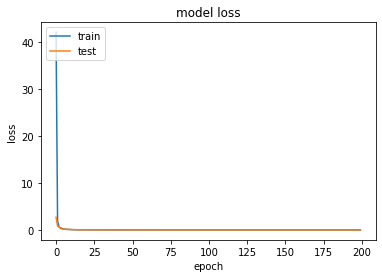

In [30]:
## gas 
# summarize history for loss
plt.plot(history_gas_mult.history['loss'])
plt.plot(history_gas_mult.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

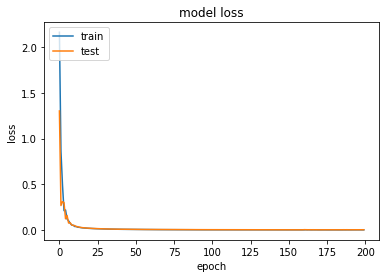

In [31]:
## liquid
# summarize history for loss
plt.plot(history_liq_mult.history['loss'])
plt.plot(history_liq_mult.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
## gas testing data set visualization
real_gas_mult = testY_gas_riser_mult.flatten()
pred_gas_mult = model_gas_mult.predict(testX_gas_riser_mult).flatten()
df_plot_gas_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult, real_gas_mult]))))
df_plot_gas_mult['ds']=range(0,len(real_gas_mult))
##liquid
real_liq_mult = testY_liq_riser_mult.flatten()
pred_liq_mult = model_liquid_mult.predict(testX_liq_riser_mult).flatten()
df_plot_liq_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult, real_gas_mult]))))
df_plot_liq_mult['ds']=range(0,len(real_liq_mult))

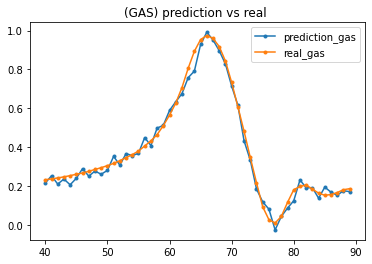

In [33]:
start = 40
end = 90
fig,ax = plt.subplots()
ax.set_title('(GAS) prediction vs real ')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

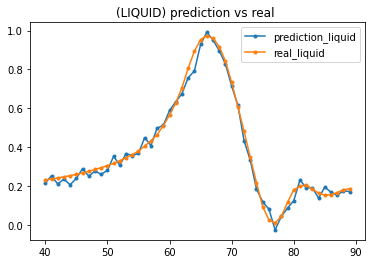

In [34]:
start = 40
end = 90
fig,ax = plt.subplots()
ax.set_title('(LIQUID) prediction vs real ')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['prediction'].iloc[start:end], marker=".", label='prediction_liquid')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['real'].iloc[start:end], marker=".", label='real_liquid')
ax.legend()

##### Trying to predict using out TCN model:

In [ ]:
# dft = dft.reset_index()
# larger tcn layer and larger FCN layer 
# larger training horizen 
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas_multi')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(dfx['ds'].iloc[20:30], dfx['prediction'].iloc[20:30], marker=".", label='pred_data_gas')
ax.plot(dfx['ds'].iloc[20:30], dfx['real'].iloc[20:30], marker=".", label='real_data_gas')
ax.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(dfx['ds'], dfx['prediction'], marker=".", label='pred_data_gas')
ax.plot(dfx['ds'], dfx['real'], marker=".", label='real_data_gas')
ax.legend()

##### The well dataset 

In [ ]:
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1
    # some outliers and spikes
    for i in random.sample(range(1, 3000), 100):
        data[i][1] = np.random.uniform(95,120)
        data[i][2] = np.random.uniform(9,51)
        data[i][3] = np.random.uniform(95,500)
        data[i][4] = np.random.uniform(-0.2,18)
        data[i][5] = np.random.uniform(360300,898900)

    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])

    return fp, headers, scaler

In [ ]:
# some trials 
# os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
# fp, headers = read_data('welltest.csv')
# df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
# for i in [1,2,3, 4]:
#     tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
#     df = pd.concat([df,tmp], axis=0)
# df =  df.set_index('DateTime')

In [ ]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/DeepAR_Prophet_VFM")
fp, headers, scaler = read_data('welltest.csv')
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
for i in [1,2,3, 4]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df =  df.set_index('DateTime')
## adding some gaussian noise 
mu, sigma = 0, 5e-4
noise = np.random.normal(mu, sigma, df.shape)
df = df + noise
## removing some values 
df = df.reset_index()
from random import randint
index = [randint(0, len(df)) for i in range(100)]
df.iloc[index,[1,2,3,4,5]] = 0

In [ ]:
fig,ax = plt.subplots()
ax.plot(df['DateTime'], df['Qo (m3/day)'], marker=".", label='real_data_w_omission')
ax.legend()
df =  df.set_index('DateTime')

In [ ]:
def multivariate_data(tseries, start_index, end_index, history_size, forecast_horizon, step=1):
    data = []
    labels = []
    for i in range(start_index, end_index -history_size +1):
        end = i+history_size
        data.append(tseries[i:end, :])
        labels.append(tseries[end:end+1, :])

    return np.asarray(data), np.asarray(labels)

In [ ]:
train = np.array(df.iloc[:int(len(df)*0.7)])
test = np.array(df.iloc[int(len(df)*0.7):])

In [ ]:
FORECAST_HORIZON = 30 #secs 
PAST_HISTORY = 60
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS = 100
METRICS = ['mse']


TCN_PARAM = {
    'nb_filters': 128,
    'kernel_size': 3,
    'nb_stacks': 1,
    'dilations': [1, 2, 4, 8, 16, 32, 64],
    'dropout_rate': 0,
    'lr':0.001
}
x_train, y_train = multivariate_data(train, 0, 2500, PAST_HISTORY, FORECAST_HORIZON, step=1)
valX , valY = multivariate_data(train, 2500, 4000, PAST_HISTORY, FORECAST_HORIZON, step=1)
testX, testY = multivariate_data(train, 4000, 5500, PAST_HISTORY, FORECAST_HORIZON, step=1)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
valX = valX.astype(np.float32)
valY = valY.astype(np.float32)
testX = testX.astype(np.float32)
testY = testY.astype(np.float32)

In [ ]:
mod = tcn(x_train.shape, 5, 'adam', 'mse', 
            nb_filters=TCN_PARAM['nb_filters'],
            kernel_size=TCN_PARAM['kernel_size'],
            nb_stacks= TCN_PARAM['nb_stacks'],
            dilations=TCN_PARAM['dilations'],
            dropout_rate=TCN_PARAM['dropout_rate'])
mod.summary()

In [ ]:
traindt = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
valdt = tf.data.Dataset.from_tensor_slices((valX, valY)).batch(BATCH_SIZE).repeat()


In [ ]:
evaluationInterval = int(np.ceil(x_train.shape[0] / BATCH_SIZE))
mod.fit(traindt, epochs=EPOCHS, steps_per_epoch=evaluationInterval, validation_data=valdt, validation_steps=evaluationInterval)

In [ ]:
mean_squared_error(mod.predict(testX).flatten(), testY.flatten())

In [ ]:
scaler.inverse_transform(testY.reshape((1441, 5)))

In [ ]:
dfy.iloc[4043:]

In [ ]:
dfReal = pd.DataFrame.from_dict(dict(zip(['p', 't', 'Qo', 'Qw', 'Qg' ],testY.reshape((1441, 5)).T)))
dfReal = dfReal. reset_index()
dfReal

In [ ]:
pred_dt = mod.predict(testX)
dfPred = pd.DataFrame.from_dict(dict(zip(['p', 't', 'Qo', 'Qw', 'Qg' ], pred_dt.T)))
dfPred = dfPred.reset_index()

In [ ]:
fig,ax = plt.subplots()
# ax.plot(dfReal['index'], dfReal['Qo'], marker=".", label='real_data_oil')
# ax.plot(dfPred['index'], dfPred['Qo'], marker=".", label='prediction_oil')
ax.plot(dfReal['index'].iloc[:300], dfReal['Qw'].iloc[:300], marker=".", label='real_data_water')
ax.plot(dfPred['index'].iloc[:300], dfPred['Qw'].iloc[:300], marker=".", label='prediction_water')
# ax.plot(dfReal['index'], dfReal['Qg'], marker=".", label='real_data_gas')
# ax.plot(dfPred['index'], dfPred['Qg'], marker=".", label='prediction_gas')
ax.legend()

In [ ]:
mean_squared_error(dfReal.iloc[:, 3:6], dfPred.iloc[:, 3:6])

In [ ]:
dfReal.iloc[:, 3:6]

#### Training of our proposed model:

In [ ]:
mse_list = []
for x in range(1):
    model = Sequential(
        layers=[
            compiled_tcn(return_sequences=False,
                         num_feat=10,
                         nb_filters=24,
                         num_classes=0,
                         kernel_size=8,
                         dilations=[2 ** i for i in range(9)],
                         nb_stacks=2,
                         max_len=30,
                         lr=0.001,
                         use_skip_connections=False,
                         regression=False,
                         dropout_rate=0,
                         output_len= 30),
            RepeatVector(1),  # output.shape = (batch, output_timesteps, 64)
            Dense(2)  # output.shape = (batch, output_timesteps, output_dim)
        ]
        )
    model.compile('adam', 'mse')
    model.fit(train_x,train_y,batch_size=64,epochs=1)
    y_pred = model.predict(np.array([test_x]))
    print(y_pred)
    print(test_y)
#     mse_cur = mean_squared_error(y_pred,test_y)
#     mse_list.append(mse_cur)
#     print(f"train_set_size:{train_x.shape[0]}")
#     print(f"y_true:{test_y}")
#     print(f"y_pred:{y_pred}")
#     print(f"mse:{mse_cur}")
# print(np.mean(mse_list))

In [ ]:
#### extra 
# only flow rates - seperate models - conov kerneal among other hyperparameters 

model = tcn(x.shape, 9, 'adam', 'mse', 
            nb_filters=TCN_PARAMS['nb_filters'],
            kernel_size=TCN_PARAMS['kernel_size'],
            nb_stacks= TCN_PARAMS['nb_stacks'],
            dilations=TCN_PARAMS['dilations'],
            dropout_rate=TCN_PARAMS['dropout_rate'])
model.summary()